In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from PIL import Image
import os

In [2]:
#import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

Instructions for updating:
non-resource variables are not supported in the long term


Should take around 3 minutes to load

In [4]:
h_dim = 1000
v_dim = 750
print("Loading Data from Memory")

root = "Train"
label_flood_dir = os.path.join(root,'Labeled','Flooded','image')
label_nonflood_dir = os.path.join(root,'Labeled','Non-Flooded','image')
flooded_img = []
nonflooded_img = []

for file in os.listdir(label_flood_dir):
    image = Image.open(os.path.join(label_flood_dir, file))
    flooded_img.append(np.array(image.resize((h_dim,v_dim))))
    
for file in os.listdir(label_nonflood_dir):
    image = Image.open(os.path.join(label_nonflood_dir, file))
    nonflooded_img.append(np.array(image.resize((h_dim,v_dim))))
print("Loaded!")

Loading Data from Memory
Loaded!


In [5]:
print("Flooded Image Shape: {}".format(flooded_img[0].shape))
print("Non_Flooded Image Shape: {}".format(nonflooded_img[0].shape))

data_img = np.vstack((np.array(flooded_img), np.array(nonflooded_img))) / 255.
data_img.shape

Flooded Image Shape: (750, 1000, 3)
Non_Flooded Image Shape: (750, 1000, 3)


(397, 750, 1000, 3)

In [6]:
import random
test = False

#n is number images from each class (flooded or non flooded)
if test == True:
    n = 20
    #train_idx = np.array([np.arange(7),np.arange(10,17)]).flatten()
    #test_idx = np.array([np.arange(7,10),np.arange(17,20)]).flatten()
else:
    n = min(len(flooded_img),len(nonflooded_img))

'''split data 50 50'''
def train_test_split(n):
    idxs = list(range(n))
    s = int(np.floor(0.8*n)) # number of images for training
    
    train_idx = []
    test_idx = []
    
    #index range to select from (flooded img range, non flooded image range)
    for s_i,e_i in [(0,len(flooded_img)),(len(flooded_img),len(data_img))]:
        
        #print(s_i,e_i,n,s)
        #get all poss indexes for set
        s_idx = list(range(s_i,e_i))
        random.shuffle(s_idx)
        
        train_idx.extend(s_idx[:s])      #first s images are for training
        test_idx.extend(s_idx[s:n])      # next n-s images are for testing. 
        #print(len(train_idx))
    
    train_idx = np.array(train_idx)
    test_idx = np.array(test_idx)
    train_idx.sort()
    test_idx.sort()
    
    train_labels = [1 if x<len(flooded_img) else 0 for x in train_idx]
    test_labels = [1 if x<len(flooded_img) else 0 for x in test_idx]

    print("Training Index: {}".format(train_idx))
    print("Testing Index: {}".format(test_idx))
    return train_idx, test_idx, train_labels, test_labels

train_idx, test_idx, train_labels, test_labels = train_test_split(n)


Training Index: [  0   1   3   5   6   7   9  10  11  12  13  14  15  17  18  19  21  22
  23  24  26  27  29  30  31  33  34  35  37  38  39  40  42  43  44  46
  47  48  49  50  52  58  72  74  76  86  89  99 103 107 121 133 137 147
 150 152 156 165 194 199 209 210 219 228 236 239 258 259 260 263 278 279
 281 282 299 311 350 363 373 396]
Testing Index: [  2   4   8  16  20  25  28  32  36  41  45  87 106 112 113 134 138 216
 261 262 312 349]


In [7]:
# convolutional layer
# x the input 
# shape is dimension of input
def conv_layer(x, shape):

    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    bias = tf.Variable(tf.constant(0.05, shape=[shape[-1]]))

    out = tf.nn.conv2d(input=x, filters=weights, strides=[1,1,1,1], padding='SAME')
    out += bias
    return out

# pooling layer
def max_pool(x, k=2):

    out = tf.nn.max_pool(value=x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
    return out

# fully connected layer
def fully_connected_layer(x, shape):

    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    bias = tf.Variable(tf.constant(0.05, shape=[shape[1]]))

    out = tf.matmul(a=x, b=weights)
    out += bias
    return out

# flatten layer
def flatten_layer(x):
    
    size = x.get_shape()[1:4].num_elements()
    out = tf.reshape(x, [-1,size])
    return out, size

# relu
relu = lambda x: tf.nn.relu(features=x)

# softmax
softmax = lambda x: tf.nn.softmax(logits=x)

# sigmoid
sigmoid = lambda x: tf.nn.sigmoid(x)

# batch norm
batch_norm = lambda x: tf.layers.batch_normalization(x)

In [40]:
# define CNN
def toy_model(x):
    
    # Six convolutional layers with max pool and ReLU
    
        #shape = [filter_size, filter_size, num_input_channels, num_filters]
    def conv_block(x,in_channels,out_channels,kernel_h=5,kernel_w =5):
        shape = [kernel_h,kernel_w,in_channels,out_channels]
        x = conv_layer(x, shape)
        x = relu(x)
        x = batch_norm(x)
        x = max_pool(x, k=2)
        return x
    
    x = conv_block(x,3,3)
    x = conv_block(x,3,3)
    x = conv_block(x,3,3)
    x = conv_block(x,3,1)
    x = conv_block(x,1,1)
    x = conv_block(x,1,1)
    
#     shape0 = [5, 5, 3, 3]
#     conv0 = conv_layer(x, shape0)
#     conv0 = relu(conv0)
#     conv0 = batch_norm(conv0)
#     conv0 = max_pool(conv0, k=2)

#     shape1 = [5, 5, 3, 3]
#     conv1 = conv_layer(conv0, shape1)
#     conv1 = relu(conv1)
#     conv1 = batch_norm(conv1)
#     conv1 = max_pool(conv1, k=2)

#     shape2 = [5, 5, 3, 3]
#     conv2 = conv_layer(conv1, shape2)
#     conv2 = relu(conv2)
#     conv2 = batch_norm(conv2)
#     conv2 = max_pool(conv2, k=2)

#     shape3 = [5, 5, 3, 1]
#     conv3 = conv_layer(conv2, shape3)
#     conv3 = relu(conv3)
#     conv3 = batch_norm(conv3)
#     conv3 = max_pool(conv3, k=2)

#     shape4 = [5, 5, 1, 1]
#     conv4 = conv_layer(conv3, shape4)
#     conv4 = relu(conv4)
#     conv4 = batch_norm(conv4)
#     conv4 = max_pool(conv4, k=2)

#     shape5 = [5, 5, 1, 1]
#     conv5 = conv_layer(conv4, shape5)
#     conv5 = relu(conv5)
#     conv5 = batch_norm(conv5)
#     conv5 = max_pool(conv5, k=2)

    # flatten output and put through a fully connected layer
    flat1, size1 = flatten_layer(conv5)
    fc1 = fully_connected_layer(flat1, [size1, 64])
    fc1 = relu(fc1)

    fc2 = fully_connected_layer(fc1, [64, 1])

    return fc2

In [41]:
# def sharpen(p):
#     T = 0.5
#     pred = p**(1./T)/(p**(1./T) + (1.-p)**(1./T))
#     return pred

In [98]:
# define inputs
x = tf.placeholder(tf.float32, [None, v_dim, h_dim, 3])
y = tf.placeholder(tf.float32, [None, 1])
y_train_true = np.array(train_labels).reshape(-1,1)
y_test_true = np.array(test_labels).reshape(-1,1)

# run model with placeholder tensors
pred = toy_model(x)

# sharpen
# pred = sharpen(pred)

# define loss
cross_entropy = tf.losses.sigmoid_cross_entropy(logits=pred, multi_class_labels=y)
cost = tf.reduce_mean(cross_entropy)

# define accuracy
pred_class = tf.round(sigmoid(pred))
pred_correct = tf.equal(pred_class, tf.cast(y, tf.float32))
accuracy = tf.reduce_mean(tf.cast(pred_correct, tf.float32))

# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

# initialize variables
init = tf.global_variables_initializer()
training_iters = 450
batch_size = 20 #len(train_idx)

In [99]:
# train model
with tf.Session(config=config) as sess:
    sess.run(init)
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    best_acc = 0.
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    num_batches = len(train_idx)//batch_size
    
    for i in range(training_iters):
        
        # Reset metrics
        loss_total = 0
        acc_total = 0
        train_results = []
   
        # Run optimization 
        # Calculate batch loss and accuracy
        for batch in range(num_batches):
            batch_x = data_img[train_idx,:,:,:][batch*batch_size:min((batch+1)*batch_size,len(train_idx))]
            batch_y = y_train_true[batch*batch_size:min((batch+1)*batch_size,len(y_train_true))]    

            feed_dict={x: batch_x, y: batch_y}
            opt = sess.run(optimizer, feed_dict=feed_dict)
            loss, acc, pred_labels = sess.run([cost, accuracy, pred_class], feed_dict=feed_dict)
            loss_total += loss
            acc_total += acc
            train_results.append(pred_labels)

        # Average metrics
        ave_loss = loss_total/num_batches
        ave_acc = acc_total/num_batches

        # Calculate accuracy for all test images
        valid_loss, test_acc, test_results = sess.run([cost, accuracy, pred_class],
                                feed_dict={x: data_img[test_idx,:,:,:], y : y_test_true})
        
        # Update metrics
        train_loss.append(ave_loss)
        test_loss.append(valid_loss)
        train_accuracy.append(ave_acc)
        test_accuracy.append(test_acc)
        if test_acc > best_acc:
            best_model_train_labels = tf.stack(tf.reshape(tf.stack(train_results),[-1,1])).eval()
            best_model_test_labels = test_results
            best_acc = test_acc
        
        # Print metrics
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(ave_loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(ave_acc)+ \
                      " ,Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 0.696784, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 1, Loss= 0.694490, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 2, Loss= 0.693930, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 3, Loss= 0.693698, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 4, Loss= 0.693570, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 5, Loss= 0.693490, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 6, Loss= 0.693438, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 7, Loss= 0.693404, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 8, Loss= 0.693380, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 9, Loss= 0.693364, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 10, Loss= 0.693353, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 11, Loss= 0.693354, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 12, Loss= 0.693348, Training Accuracy= 0.50000 ,Testing A

Iter 104, Loss= 0.693120, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 105, Loss= 0.693119, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 106, Loss= 0.693119, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 107, Loss= 0.693116, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 108, Loss= 0.693116, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 109, Loss= 0.693115, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 110, Loss= 0.693112, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 111, Loss= 0.693110, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 112, Loss= 0.693109, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 113, Loss= 0.693106, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 114, Loss= 0.693103, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 115, Loss= 0.693100, Training Accuracy= 0.50000 ,Testing Accuracy: 0.50000
Iter 116, Loss= 0.693096, Training Accur

Iter 207, Loss= 0.230240, Training Accuracy= 0.86250 ,Testing Accuracy: 0.77273
Iter 208, Loss= 0.227473, Training Accuracy= 0.86250 ,Testing Accuracy: 0.77273
Iter 209, Loss= 0.224264, Training Accuracy= 0.86250 ,Testing Accuracy: 0.77273
Iter 210, Loss= 0.220807, Training Accuracy= 0.86250 ,Testing Accuracy: 0.77273
Iter 211, Loss= 0.219024, Training Accuracy= 0.86250 ,Testing Accuracy: 0.77273
Iter 212, Loss= 0.214755, Training Accuracy= 0.86250 ,Testing Accuracy: 0.77273
Iter 213, Loss= 0.215842, Training Accuracy= 0.86250 ,Testing Accuracy: 0.77273
Iter 214, Loss= 0.209714, Training Accuracy= 0.87500 ,Testing Accuracy: 0.77273
Iter 215, Loss= 0.215198, Training Accuracy= 0.86250 ,Testing Accuracy: 0.77273
Iter 216, Loss= 0.210184, Training Accuracy= 0.87500 ,Testing Accuracy: 0.77273
Iter 217, Loss= 0.205889, Training Accuracy= 0.87500 ,Testing Accuracy: 0.77273
Iter 218, Loss= 0.208102, Training Accuracy= 0.87500 ,Testing Accuracy: 0.77273
Iter 219, Loss= 0.195996, Training Accur

Iter 310, Loss= 0.100256, Training Accuracy= 0.87500 ,Testing Accuracy: 0.77273
Iter 311, Loss= 0.100093, Training Accuracy= 0.87500 ,Testing Accuracy: 0.77273
Iter 312, Loss= 0.099642, Training Accuracy= 0.87500 ,Testing Accuracy: 0.77273
Iter 313, Loss= 0.099217, Training Accuracy= 0.87500 ,Testing Accuracy: 0.77273
Iter 314, Loss= 0.098996, Training Accuracy= 0.87500 ,Testing Accuracy: 0.77273
Iter 315, Loss= 0.098816, Training Accuracy= 0.87500 ,Testing Accuracy: 0.77273
Iter 316, Loss= 0.098487, Training Accuracy= 0.87500 ,Testing Accuracy: 0.77273
Iter 317, Loss= 0.098617, Training Accuracy= 0.87500 ,Testing Accuracy: 0.77273
Iter 318, Loss= 0.098672, Training Accuracy= 0.93750 ,Testing Accuracy: 0.77273
Iter 319, Loss= 0.098372, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 320, Loss= 0.097927, Training Accuracy= 0.98750 ,Testing Accuracy: 0.81818
Iter 321, Loss= 0.097741, Training Accuracy= 0.97500 ,Testing Accuracy: 0.81818
Iter 322, Loss= 0.097428, Training Accur

Iter 413, Loss= 0.084236, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 414, Loss= 0.084138, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 415, Loss= 0.084055, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 416, Loss= 0.084004, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 417, Loss= 0.083902, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 418, Loss= 0.083812, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 419, Loss= 0.083761, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 420, Loss= 0.083670, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 421, Loss= 0.083585, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 422, Loss= 0.083498, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 423, Loss= 0.083404, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 424, Loss= 0.083314, Training Accuracy= 1.00000 ,Testing Accuracy: 0.77273
Iter 425, Loss= 0.083219, Training Accur

KeyboardInterrupt: 

In [100]:
best_model_train_labels

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],

In [101]:
best_model_test_labels

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.]], dtype=float32)

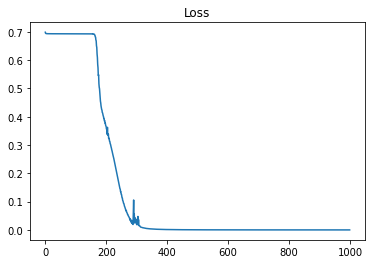

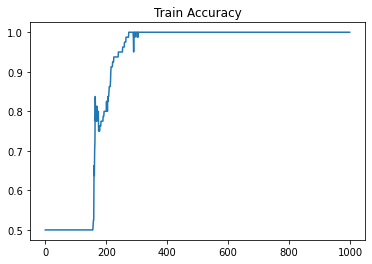

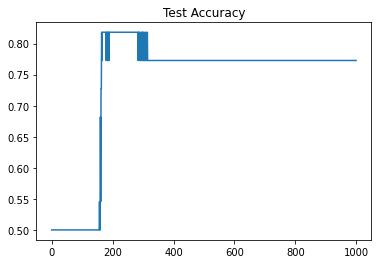

In [44]:
for title, data in {"Loss":train_loss,"Train Accuracy": train_accuracy, "Test Accuracy": test_accuracy}.items():
    plt.plot(data)
    plt.title(title)
    plt.show()